# Big data workshop: D1 assignment. Part 2

In [2]:
# import packages
import csv
import requests
from bs4 import BeautifulSoup

#  Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import re
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/xmr./nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/xmr./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xmr./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/xmr./nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Scrape Psych News

In [3]:
url = 'https://psych.ucsb.edu/news-events/news'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

news_items = soup.find_all('div', class_='all-news-wrap')

with open('psych_news.csv', mode='w', encoding='utf-8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Title', 'Date', 'URL', 'text'])

    for item in news_items:
        date = item.find('div', class_='fancy-date').get_text(separator=' ').strip()
        link = item.find('h3').find('a')
        title = link.text.strip()
        news_url = link['href']

        # Check if URL has a scheme and add one if missing
        if not news_url.startswith('http'):
            news_url = f"https://psych.ucsb.edu{news_url}"

        # Request news article page
        news_response = requests.get(news_url)
        news_soup = BeautifulSoup(news_response.content, 'html.parser')

        # Extract news content
        content = news_soup.find('div', class_='news__body').text.strip()

        writer.writerow([title, date, news_url, content])


In [4]:
df = pd.read_csv('psych_news.csv')
df.head()

,Title,Date,URL,text
0,Research on physical activity and relationship...,Nov \n 2 \n 2023,https://psych.ucsb.edu/news-events/news/2023/r...,Research by PBS Graduate student Paige Harris ...
1,The Ann S. Bowers Women’s Brain Health Initiat...,Nov \n 1 \n 2023,https://psych.ucsb.edu/news-events/news/2023/a...,The Ann S. Bowers Women’s Brain Health Initiat...
2,PBS grad Alisa Bedrov’s research on secrecy hi...,Sep \n 18 \n 2023,https://psych.ucsb.edu/news-events/news/2023/p...,A new study authored by PBS graduate student A...
3,Distinguished PBS Professor Emeritus Brenda Ma...,Sep \n 12 \n 2023,https://psych.ucsb.edu/news-events/news/2023/d...,Distinguished PBS Professor Emeritus Brenda Ma...
4,PBS professor René Weber finds that moral reas...,Sep \n 11 \n 2023,https://psych.ucsb.edu/news-events/news/2023/p...,"Santa Barbara, CA\nEvery day we encounter circ..."


## Text Preprocessing

In [5]:
def clean_text(text):
    # uncapitalize text
    text = str(text).lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization  - convert sentences to words
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization - convert words to root word
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Rejoin tokens into a string
    return ' '.join(lemmatized_tokens)

In [6]:
# apply clean_text function to text column
df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

,Title,Date,URL,text,cleaned_text
0,Research on physical activity and relationship...,Nov \n 2 \n 2023,https://psych.ucsb.edu/news-events/news/2023/r...,Research by PBS Graduate student Paige Harris ...,research pb graduate student paige harris prof...
1,The Ann S. Bowers Women’s Brain Health Initiat...,Nov \n 1 \n 2023,https://psych.ucsb.edu/news-events/news/2023/a...,The Ann S. Bowers Women’s Brain Health Initiat...,ann bower woman brain health initiative direct...
2,PBS grad Alisa Bedrov’s research on secrecy hi...,Sep \n 18 \n 2023,https://psych.ucsb.edu/news-events/news/2023/p...,A new study authored by PBS graduate student A...,new study authored pb graduate student alisa b...
3,Distinguished PBS Professor Emeritus Brenda Ma...,Sep \n 12 \n 2023,https://psych.ucsb.edu/news-events/news/2023/d...,Distinguished PBS Professor Emeritus Brenda Ma...,distinguished pb professor emeritus brenda maj...
4,PBS professor René Weber finds that moral reas...,Sep \n 11 \n 2023,https://psych.ucsb.edu/news-events/news/2023/p...,"Santa Barbara, CA\nEvery day we encounter circ...",santa barbara ca every day encounter circumsta...


In [7]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']

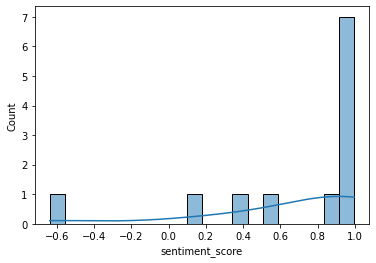

In [8]:
df['sentiment_score'] = df['text'].apply(lambda x: get_sentiment_score(clean_text(x)))
sns.histplot(data=df, x='sentiment_score', bins=20, kde=True)
plt.show()

In [9]:
df.loc[df['sentiment_score'] < 0]

,Title,Date,URL,text,cleaned_text,sentiment_score
4,PBS professor René Weber finds that moral reas...,Sep \n 11 \n 2023,https://psych.ucsb.edu/news-events/news/2023/p...,"Santa Barbara, CA\nEvery day we encounter circ...",santa barbara ca every day encounter circumsta...,-0.6369


## wordcloud

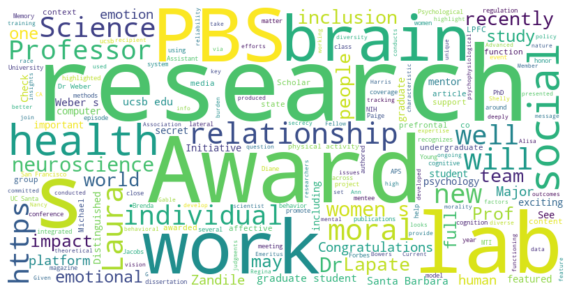

In [10]:
from wordcloud import WordCloud, STOPWORDS

# Combine all text data into a single string
text = " ".join(content for content in df.text)

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, max_font_size=150, background_color="white").generate(text)

# # Display the generated image
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()